## Reproduce Published results with Starfish

The MERFISH.zip file needed to run this notebook is downloadable [here](https://drive.google.com/open?id=1YQ3QcOBIoL6Yz3SStC0vigbVaH0C7DkW)

This notebook walks through a workflow that reproduces a MERFISH result for one field of view using the starfish package. It assumes you have unzipped MERFISH.zip in the same directory. Thus, you should see: 

```
MERFISH/
Starfish MERFISH Pipeline - U2O2 Cell Culture - 1 FOV.ipynb
```

## Load tiff stack and visualize one field of view

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
from showit import image, tile
import time
import pprint

%matplotlib inline

from starfish.io import Stack

# load in current directory so we can also grab the benchmark results later
s = Stack()
s.read('http://czi.starfish.data.public.s3-website-us-east-1.amazonaws.com/MERFISH/fov_001/experiment.json')

# data from one FOV correspond to 16 single plane images as shown here (see below for details)
# tile(s.squeeze());  

## Show input file format that specifies how the tiff stack is organized

The stack contains multiple images corresponding to the channel and hybridization round. MERFISH builds a 16 bit barcode from 8 hybridization rounds, each of which measures two channels that correspond to contiguous (but not necessarily consistently ordered) bits of the barcode. 

The MERFISH computational pipeline also constructs a scalar that corrects for intensity differences across each of the 16 images, e.g., one scale factor per bit position.

The stacks in this example are pre-registered using fiduciary beads. 

In [2]:
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(s.org)

{ 'auxiliary_images': { 'nuclei': { 'coordinates': { 'x': [0.0, 0.0001],
                                                     'y': [0.0, 0.0001]},
                                    'file': 'dapi.tiff',
                                    'tile_format': 'TIFF',
                                    'tile_shape': [2048, 2048]}},
  'hybridization_images': 'hybridization.json',
  'version': '0.0.0'}


## Visualize codebook

The MERFISH codebook maps each barcode to a gene (or blank) feature. The codes in the MERFISH codebook are constructed from a 4-hamming error correcting code with exactly 4 "on" bits per barcode

In [3]:
# TODO ambrosejcarr: update this to point at the s3 bucket
codebook = pd.read_csv('https://s3.amazonaws.com/czi.starfish.data.public/MERFISH/codebook.csv', dtype={'barcode': object})
codebook.head(20)

,barcode,gene
0,0011100000001000,Blank-1
1,1001100100000000,Blank-10
2,0011000100100000,Blank-2
3,0011010001000000,Blank-3
4,0010010000001100,Blank-4
5,0010001000101000,Blank-5
6,1000101000001000,Blank-6
7,0101100000000010,Blank-7
8,0001000001001100,Blank-8
9,0000100100101000,Blank-9


## Filter and scale raw data before decoding

In [4]:
from starfish.pipeline.filter.gaussian_high_pass import GaussianHighPass
from starfish.pipeline.filter.gaussian_low_pass import GaussianLowPass
from starfish.pipeline.filter.richardson_lucy_deconvolution import DeconvolvePSF
from starfish.viz import tile_lims

Begin filtering with a high pass filter to remove background signal.

In [5]:
# bit_map_flag = True orders the list of single-plane images by bit
# TODO ambrosejcarr: why is this important? This got dropped in the conversion to pipeline components
ghp = GaussianHighPass(sigma=3)
ghp.filter(s)

The below algorithm deconvolves out the point spread function introduced by the microcope and is specifically designed for this use case. The number of iterations is an important parameter that needs careful optimization. 

In [6]:
dpsf = DeconvolvePSF(num_iter=15, sigma=2)
dpsf.filter(s)

Recall that the image is pre-registered, as stated above. Despite this, individual RNA molecules may still not be perfectly aligned across hybridization rounds. This is crucial in order to read out a measure of the itended barcode (across hybridization rounds) in order to map it to the codebook. To solve for potential mis-alignment, the images can be blurred with a 1-pixel Gaussian kernel. The risk here is that this will obfuscate signals from nearby molecules. 

A local search in pixel space across hybridization rounds can also solve this. 

In [7]:
glp = GaussianLowPass(sigma=1)
glp.filter(s)

Use MERFISH-calculated size factors to scale the channels across the hybridization rounds and visualize the resulting filtered and scaled images. Right now we have to extract this information from the metadata and apply this transformation manually. 

In [8]:
scale_factors = {}
tile_barcode_indices = {}
for tile in s.image._image_partition.tiles():
    h = tile.indices['h']
    c = tile.indices['c']
    bci = tile.extras['barcode_index']
    sf = tile.extras['scale_factor']
    scale_factors[(h, c)] = sf
    tile_barcode_indices[(h, c)] = bci

In [9]:
# this is a scaling method. Can we use image.apply here? We could, but we need H & C. Can we expose H & C (we should!)
# at least we can do it with get_slice and set_slice right now.

for indices in s.image._iter_indices():
    data = s.image.get_slice(indices)[0]
    scaled = data / scale_factors[indices['h'], indices['c']]
    s.image.set_slice(indices, scaled)

In [10]:
from scipy.stats import scoreatpercentile

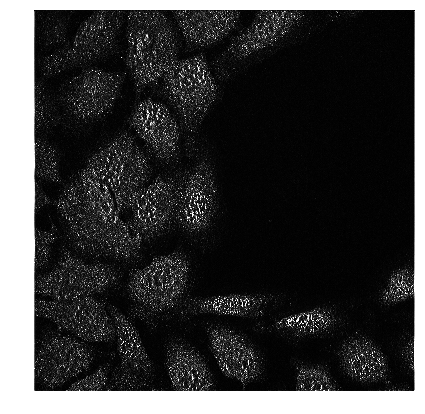

In [11]:
mp = s.max_proj('h', 'c', 'z')
clim = scoreatpercentile(mp, [0.5, 99.5])
image(mp, clim=clim)

## Use spot-detector to create 'encoder' table  for standardized input  to decoder

Each pipeline exposes a spot detector, and this spot detector translates the filtered image into an encoded table by detecting spots. The table contains the spot_id, the corresponding intensity (val) and the channel (ch), hybridization round (hyb), and bit position (bit) of each spot. 

The Encoder table is the hypothesized standardized file format for the output of a spot detector, and is the first format that is not an image stack. Below we show how this data representation looks for a single spot_id.

In [23]:
from starfish.spots.pixel import PixelSpotDetector

# create 'encoder table' standard (tidy) file format. each pixel is a 'spot'
p = PixelSpotDetector(s)
encoded = p.detect()
ind = np.random.randint(low=0,high=2048*2048)
encoded[encoded.spot_id==ind].head(16)

,spot_id,barcode_index,intensity,c,h,scale_factor
2772150,2772150,0,0.104932,0,0,104.830
6966454,2772150,1,0.197109,1,0,45.660
11160758,2772150,2,0.504668,1,1,41.184
15355062,2772150,3,0.169969,0,1,87.186
19549366,2772150,4,0.089341,0,2,89.545
23743670,2772150,5,0.044712,1,2,44.731
27937974,2772150,6,0.382142,0,3,107.290
32132278,2772150,7,0.138018,1,3,50.718
36326582,2772150,8,0.588504,1,4,44.572
40520886,2772150,9,0.134614,0,4,83.262


## Decode

Each assay type also exposes a decoder. A decoder translates each spot (spot_id) in the encoded table into a gene that matches a barcode in the codebook. The goal is to decode and output a quality score, per spot, that describes the confidence in the decoding. Recall that in the MERFISH pipeline, each 'spot' is actually a 16 dimensional vector, one per pixel in the image. From here on, we will refer to these as pixel vectors. Once these pixel vectors are decoded into gene values, contiguous pixels that are decoded to the same gene are labeled as 'spots' via a connected components labeler. We shall refer to the latter as spots.

There are hard and soft decodings -- hard decoding is just looking for the max value in the code book. Soft decoding, by contrast, finds the closest code by distance in intensity. Because different assays each have their own intensities and error modes, we leave decoders as user-defined functions. 

For MERFISH, which uses soft decoding, there are several parameters which are important to determining the result of the decoding method: 

### Distance threshold
In MERFISH, each pixel vector is a 16d vector that we want to map onto a barcode via minimum euclidean distance. Each barcode in the codebook, and each pixel vector is first mapped to the unit sphere by L2 normalization. As such, the maximum distance between a pixel vector and the nearest single-bit error barcode is 0.5176. As such, the decoder only accepts pixel vectors that are below this distance for assignment to a codeword in the codebook. 

### Magnitude threshold
This is a signal floor for decoding. Pixel vectors with an L2 norm below this floor are not considered for decoding. 

### Area threshold
Contiguous pixels that decode to the same gene are called as spots via connected components labeling. The minimum area of these spots are set by this parameter. The intuition is that pixel vectors, that pass the distance and magnitude thresholds, shold probably not be trusted as genes as the mRNA transcript would be too small for them to be real. This parameter can be set based on microscope resolution and signal amplification strategy.

### Crop size 
The crop size crops the image by a number of pixels large enough to eliminate parts of the image that suffer from boundary effects from both signal aquisition (e.g., FOV overlap) and image processing. Here this value is 40.

Given these three thresholds, for each pixel vector, the decoder picks the closest code (minimum distance) that satisfies each of the above thresholds, where the distance is calculated between the code and a normalized intensity vector and throws away subsequent spots that are too small.

In [26]:
encoded.head()

,spot_id,barcode_index,intensity,c,h,scale_factor
0,0,0,0.019079,0,0,104.83
1,1,0,0.066775,0,0,104.83
2,2,0,0.114471,0,0,104.83
3,3,0,0.095393,0,0,104.83
4,4,0,0.047696,0,0,104.83


In [27]:
from starfish.decoders.merfish import MerfishDecoder

decoder = MerfishDecoder(codebook)

decoded = decoder._decode(encoded,
                    img_size=(2048, 2048),
                    distance_threshold=0.5176,
                    magnitude_threshold=1,
                    area_threshold=2,
                    crop_size=40
                   )

res = decoded.result  # this should be consistent across assays; 
# this one doesn't have a quality, but it should eventually converge to a shared type
res.head()

,area,barcode,x,y,spot_id,gene
0,3,0000100010100001,40.000000,90.000000,0,EGFR
1,3,0101100000000010,40.333333,159.333333,1,Blank-7
2,2,0000000001010110,40.000000,345.500000,2,NKTR
3,2,0110001001000000,40.500000,413.000000,3,PTPN14
4,3,1000010100000100,40.000000,514.000000,4,SLC5A3


In the above method, the private method of the decoder is used, which exposes additional metadata about the spots. 

In [28]:
print('Additional metadata:')
[f for f in dir(decoded) if not f.startswith('_')]

Additional metadata:


['count', 'decoded_img', 'index', 'label_img', 'result', 'spot_props']

Spot attributes are stored as skimage RegionProperties attributes

In [29]:
decoded.spot_props[:3]

## Compare to results from paper 

The below plot aggregates gene copy number across single cells in the field of view and compares the results to the published intensities in the MERFISH paper. 

To make this match perfectly, run deconvolution 15 times instead of 14. As presented below, STARFISH displays a lower detection rate.  

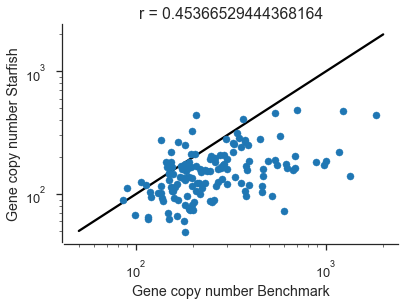

In [30]:
import seaborn as sns
sns.set_context('talk')
sns.set_style('ticks')

bench = pd.read_csv(os.path.join('MERFISH', 'benchmark_results.csv'), dtype = {'barcode':object})
x_cnts = res.groupby('gene').count()['area']
y_cnts = bench.groupby('gene').count()['area']
tmp = pd.concat([x_cnts, y_cnts], axis=1, join='inner').values
r = np.corrcoef(tmp[:,1], tmp[:,0])[0,1]

x = np.linspace(50, 2000)
plt.scatter(tmp[:,1],tmp[:,0], 50,zorder=2)
plt.plot(x,x,'-k',zorder=1)

plt.xlabel('Gene copy number Benchmark')
plt.ylabel('Gene copy number Starfish')
plt.xscale('log')
plt.yscale('log')
plt.title('r = {}'.format(r))

sns.despine(offset=2)

## Visualize results

This image applies a pseudo-color to each gene channel to visualize the position and size of all called spots in a subset of the test image

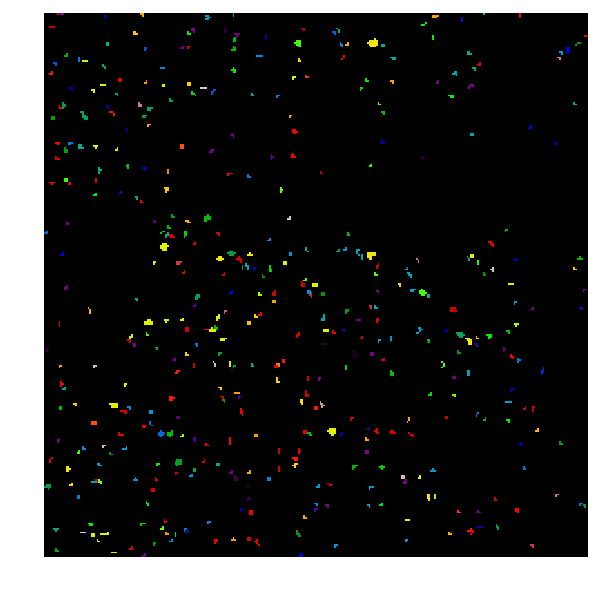

In [31]:
props = decoded.spot_props
area_lookup = lambda x: 0 if x == 0 else props[x-1].area
vfunc = np.vectorize(area_lookup)
mask = vfunc(decoded.label_img)
image((decoded.decoded_img*(mask > 2))[200:500,200:500], cmap = 'nipy_spectral', size=10)